In [9]:
import pickle
import os
import numpy as np
directory = r'D:\github\Cricket-Prediction\data\5_pytorchData'

import torch
from torch.utils.data import Dataset

# Augment the data by creating new samples with different combinations of overs
def augment_data(team_stats_list, player_stats_list, ball_stats_list, over_segments=np.arange(7, 40)): 
    augmented_team_stats = []
    augmented_player_stats = []
    augmented_ball_stats = []
    
    for team_stats, player_stats, ball_stats in zip(team_stats_list, player_stats_list, ball_stats_list):
        total_overs = ball_stats.shape[0] // 6  # Assuming 6 balls per over
        for segment in over_segments:
            if total_overs >= segment:
                end_idx = segment * 6
                augmented_team_stats.append(team_stats)
                augmented_player_stats.append(player_stats)
                augmented_ball_stats.append(ball_stats[:end_idx])
    
    return augmented_team_stats, augmented_player_stats, augmented_ball_stats

# Create a custom Dataset
class CricketDataset(Dataset):
    def __init__(self, team_stats_list, player_stats_list, ball_stats_list):
        self.team_stats_list = team_stats_list
        self.player_stats_list = player_stats_list
        self.ball_stats_list = ball_stats_list

    def __len__(self):
        return len(self.team_stats_list)

    def __getitem__(self, idx):
        team_input = torch.tensor(self.team_stats_list[idx], dtype=torch.float32)
        team_input = team_input.squeeze()  # Remove extra dimensions
        player_input = torch.tensor(self.player_stats_list[idx], dtype=torch.float32)
        ball_stats = torch.tensor(self.ball_stats_list[idx], dtype=torch.float32)
        # Assuming the last column is the label
        ball_input = ball_stats[:, :-1]
        label = ball_stats[0, -1]
        return team_input, player_input, ball_input, label

# Define a collate function to handle variable-length sequences
def collate_fn(batch):
    team_inputs = []
    player_inputs = []
    ball_inputs = []
    labels = []
    ball_lengths = []

    for team_input, player_input, ball_input, label in batch:
        team_inputs.append(team_input)
        player_inputs.append(player_input)
        ball_inputs.append(ball_input)
        labels.append(label)
        ball_lengths.append(ball_input.shape[0])

    # Pad ball_inputs to the maximum sequence length in the batch
    max_seq_len = max(ball_lengths)
    padded_ball_inputs = torch.zeros(len(ball_inputs), max_seq_len, ball_inputs[0].shape[1])
    for i, ball_input in enumerate(ball_inputs):
        seq_len = ball_input.shape[0]
        padded_ball_inputs[i, :seq_len, :] = ball_input

    team_inputs = torch.stack(team_inputs)
    player_inputs = torch.stack(player_inputs)
    labels = torch.tensor(labels, dtype=torch.float32)
    return team_inputs, player_inputs, padded_ball_inputs, labels, ball_lengths


train_dataloader = pickle.load(open(os.path.join(directory, 'train_dataloader.pkl'), 'rb'))
val_dataloader = pickle.load(open(os.path.join(directory, 'val_dataloader.pkl'), 'rb'))
test_dataloader = pickle.load(open(os.path.join(directory, 'test_dataloader.pkl'), 'rb'))

In [10]:
import torch.nn as nn
import torch.nn.functional as F

# Define the models
class TeamStatsModel(nn.Module):
    def __init__(self, input_size):
        super(TeamStatsModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.5),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.5),
            nn.Linear(32, 16),
            nn.ReLU()
        )

    def forward(self, x):
        return self.model(x)

class PlayerStatsModel(nn.Module):
    def __init__(self, input_size, seq_len):
        super(PlayerStatsModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=32, kernel_size=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(64 * ((seq_len - 4) // 4), 16)  # Adjust input size dynamically

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Convert to (batch, channels, seq_len)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.flatten(x)
        x = F.relu(self.fc(x))
        return x

class BallToBallModel(nn.Module):
    def __init__(self, input_dim):
        super(BallToBallModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, 128, batch_first=True, bidirectional=False)  # Not bidirectional
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128, 16)  # Adjust input size to 128

    def forward(self, x, lengths):
        # Pack the sequences
        x_packed = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        output_packed, (hn, cn) = self.lstm(x_packed)
        # Use the final hidden state directly
        hn = hn[-1,:,:]
        x = self.dropout(hn)
        x = F.relu(self.fc(x))
        return x

class CombinedModel(nn.Module):
    def __init__(self, team_input_size, player_input_size, player_seq_len, ball_input_dim):
        super(CombinedModel, self).__init__()
        self.team_model = TeamStatsModel(team_input_size)
        self.player_model = PlayerStatsModel(player_input_size, player_seq_len)
        self.ball_model = BallToBallModel(ball_input_dim)
        self.fc = nn.Sequential(
            nn.Linear(16+16+16, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, team_input, player_input, ball_input, ball_lengths):
        team_output = self.team_model(team_input)
        player_output = self.player_model(player_input)
        ball_output = self.ball_model(ball_input, ball_lengths)
        combined = torch.cat((team_output, player_output, ball_output), dim=1)
        output = self.fc(combined)
        return output.squeeze()

In [15]:
import torch.optim as optim
import numpy as np
from tqdm import tqdm

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
team_input_size = train_dataloader.dataset[0][0].shape[0]
player_input_size = train_dataloader.dataset[0][1].shape[1]
player_seq_len = train_dataloader.dataset[0][1].shape[0]  # Sequence length for player stats
ball_input_dim = train_dataloader.dataset[0][2].shape[1]

model = CombinedModel(team_input_size, player_input_size, player_seq_len, ball_input_dim).to(device)  # Move model to GPU

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)  # Weight decay for regularization
criterion = nn.BCELoss()

# Implement early stopping
best_loss = np.inf
patience = 10
trigger_times = 0

# Training loop with tqdm
num_epochs = 25
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for team_input, player_input, ball_input, labels, ball_lengths in progress_bar:
        team_input, player_input, ball_input, labels = team_input.to(device), player_input.to(device), ball_input.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = model(team_input, player_input, ball_input, ball_lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # Calculate accuracy
        predictions = (outputs > 0.5).float()
        correct_predictions += (predictions == labels).sum().item()
        total_predictions += labels.size(0)
        
        progress_bar.set_postfix(loss=loss.item())
    avg_train_loss = running_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_predictions
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Validation
    model.eval()
    val_running_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0
    with torch.no_grad():
        for team_input, player_input, ball_input, labels, ball_lengths in val_dataloader:
            team_input, player_input, ball_input, labels = team_input.to(device), player_input.to(device), ball_input.to(device), labels.to(device)  # Move data to GPU
            outputs = model(team_input, player_input, ball_input, ball_lengths)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            
            # Calculate accuracy
            predictions = (outputs > 0.5).float()
            val_correct_predictions += (predictions == labels).sum().item()
            val_total_predictions += labels.size(0)
    avg_val_loss = val_running_loss / len(val_dataloader)
    val_accuracy = val_correct_predictions / val_total_predictions
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Early stopping logic
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        trigger_times = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print('Early stopping!')
            break

# Save the model
torch.save(model.state_dict(), 't20i.pth')

Epoch 1/25: 100%|██████████| 1683/1683 [00:51<00:00, 32.96it/s, loss=0.649]


Epoch [1/25], Train Loss: 0.6913, Train Accuracy: 0.5226
Epoch [1/25], Val Loss: 0.6797, Val Accuracy: 0.5901


Epoch 2/25: 100%|██████████| 1683/1683 [00:53<00:00, 31.19it/s, loss=0.647]


Epoch [2/25], Train Loss: 0.6744, Train Accuracy: 0.5799
Epoch [2/25], Val Loss: 0.6553, Val Accuracy: 0.6143


Epoch 3/25: 100%|██████████| 1683/1683 [00:56<00:00, 29.99it/s, loss=0.587]


Epoch [3/25], Train Loss: 0.6485, Train Accuracy: 0.6251
Epoch [3/25], Val Loss: 0.6137, Val Accuracy: 0.6661


Epoch 4/25: 100%|██████████| 1683/1683 [00:55<00:00, 30.45it/s, loss=0.618]


Epoch [4/25], Train Loss: 0.6053, Train Accuracy: 0.6711
Epoch [4/25], Val Loss: 0.5509, Val Accuracy: 0.7228


Epoch 5/25: 100%|██████████| 1683/1683 [00:55<00:00, 30.47it/s, loss=0.52] 


Epoch [5/25], Train Loss: 0.5518, Train Accuracy: 0.7183
Epoch [5/25], Val Loss: 0.4885, Val Accuracy: 0.7563


Epoch 6/25: 100%|██████████| 1683/1683 [00:54<00:00, 30.68it/s, loss=0.456]


Epoch [6/25], Train Loss: 0.4936, Train Accuracy: 0.7605
Epoch [6/25], Val Loss: 0.4455, Val Accuracy: 0.7879


Epoch 7/25: 100%|██████████| 1683/1683 [00:54<00:00, 30.69it/s, loss=0.385]


Epoch [7/25], Train Loss: 0.4466, Train Accuracy: 0.7861
Epoch [7/25], Val Loss: 0.3797, Val Accuracy: 0.8252


Epoch 8/25: 100%|██████████| 1683/1683 [00:55<00:00, 30.26it/s, loss=0.335]


Epoch [8/25], Train Loss: 0.4039, Train Accuracy: 0.8118
Epoch [8/25], Val Loss: 0.3547, Val Accuracy: 0.8370


Epoch 9/25: 100%|██████████| 1683/1683 [00:54<00:00, 30.74it/s, loss=0.399]


Epoch [9/25], Train Loss: 0.3665, Train Accuracy: 0.8318
Epoch [9/25], Val Loss: 0.3377, Val Accuracy: 0.8362


Epoch 10/25: 100%|██████████| 1683/1683 [00:54<00:00, 30.89it/s, loss=0.336]


Epoch [10/25], Train Loss: 0.3367, Train Accuracy: 0.8482
Epoch [10/25], Val Loss: 0.3044, Val Accuracy: 0.8624


Epoch 11/25: 100%|██████████| 1683/1683 [00:56<00:00, 29.70it/s, loss=0.413]


Epoch [11/25], Train Loss: 0.3089, Train Accuracy: 0.8633
Epoch [11/25], Val Loss: 0.2588, Val Accuracy: 0.8857


Epoch 12/25: 100%|██████████| 1683/1683 [00:51<00:00, 32.40it/s, loss=0.145] 


Epoch [12/25], Train Loss: 0.2863, Train Accuracy: 0.8733
Epoch [12/25], Val Loss: 0.3250, Val Accuracy: 0.8574


Epoch 13/25: 100%|██████████| 1683/1683 [00:50<00:00, 33.45it/s, loss=0.519] 


Epoch [13/25], Train Loss: 0.2653, Train Accuracy: 0.8839
Epoch [13/25], Val Loss: 0.2105, Val Accuracy: 0.9119


Epoch 14/25: 100%|██████████| 1683/1683 [00:50<00:00, 33.54it/s, loss=0.177] 


Epoch [14/25], Train Loss: 0.2458, Train Accuracy: 0.8927
Epoch [14/25], Val Loss: 0.2119, Val Accuracy: 0.9081


Epoch 15/25: 100%|██████████| 1683/1683 [00:50<00:00, 33.53it/s, loss=0.209] 


Epoch [15/25], Train Loss: 0.2327, Train Accuracy: 0.8997
Epoch [15/25], Val Loss: 0.1995, Val Accuracy: 0.9081


Epoch 16/25: 100%|██████████| 1683/1683 [00:49<00:00, 34.09it/s, loss=0.192] 


Epoch [16/25], Train Loss: 0.2119, Train Accuracy: 0.9077
Epoch [16/25], Val Loss: 0.2200, Val Accuracy: 0.9008


Epoch 17/25: 100%|██████████| 1683/1683 [00:49<00:00, 33.69it/s, loss=0.21]  


Epoch [17/25], Train Loss: 0.2039, Train Accuracy: 0.9126
Epoch [17/25], Val Loss: 0.1761, Val Accuracy: 0.9259


Epoch 18/25: 100%|██████████| 1683/1683 [00:51<00:00, 32.39it/s, loss=0.303] 


Epoch [18/25], Train Loss: 0.1913, Train Accuracy: 0.9188
Epoch [18/25], Val Loss: 0.1832, Val Accuracy: 0.9175


Epoch 19/25: 100%|██████████| 1683/1683 [00:54<00:00, 30.63it/s, loss=0.184] 


Epoch [19/25], Train Loss: 0.1784, Train Accuracy: 0.9251
Epoch [19/25], Val Loss: 0.1205, Val Accuracy: 0.9496


Epoch 20/25: 100%|██████████| 1683/1683 [00:51<00:00, 32.68it/s, loss=0.142] 


Epoch [20/25], Train Loss: 0.1710, Train Accuracy: 0.9287
Epoch [20/25], Val Loss: 0.1418, Val Accuracy: 0.9349


Epoch 21/25: 100%|██████████| 1683/1683 [00:51<00:00, 32.70it/s, loss=0.201] 


Epoch [21/25], Train Loss: 0.1572, Train Accuracy: 0.9350
Epoch [21/25], Val Loss: 0.1709, Val Accuracy: 0.9250


Epoch 22/25: 100%|██████████| 1683/1683 [00:54<00:00, 30.82it/s, loss=0.195] 


Epoch [22/25], Train Loss: 0.1537, Train Accuracy: 0.9365
Epoch [22/25], Val Loss: 0.1556, Val Accuracy: 0.9253


Epoch 23/25: 100%|██████████| 1683/1683 [00:53<00:00, 31.23it/s, loss=0.245] 


Epoch [23/25], Train Loss: 0.1444, Train Accuracy: 0.9407
Epoch [23/25], Val Loss: 0.1018, Val Accuracy: 0.9519


Epoch 24/25: 100%|██████████| 1683/1683 [00:54<00:00, 30.72it/s, loss=0.11]  


Epoch [24/25], Train Loss: 0.1402, Train Accuracy: 0.9422
Epoch [24/25], Val Loss: 0.1526, Val Accuracy: 0.9363


Epoch 25/25: 100%|██████████| 1683/1683 [00:54<00:00, 30.69it/s, loss=0.303] 


Epoch [25/25], Train Loss: 0.1353, Train Accuracy: 0.9451
Epoch [25/25], Val Loss: 0.1297, Val Accuracy: 0.9450


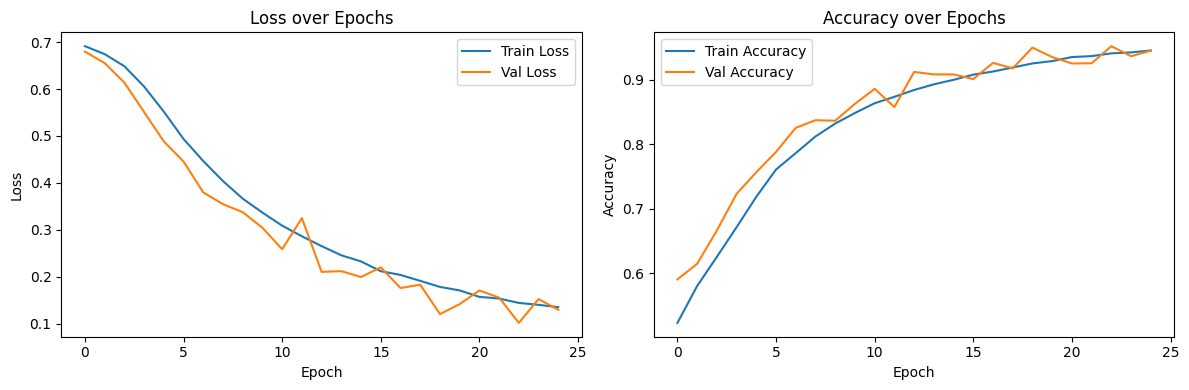

In [ ]:
import matplotlib.pyplot as plt
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.tight_layout()
plt.savefig('training_validation_history.png')
plt.show()

In [36]:
# Initialize the model
model = CombinedModel(team_input_size, player_input_size, player_seq_len, ball_input_dim).to(device)

# Load the t20i model weights
model.load_state_dict(torch.load('t20i.pth',weights_only=True))

# Testing
model.eval()
test_correct_predictions = 0
test_total_predictions = 0
test_running_loss = 0.0
with torch.no_grad():
    for team_input, player_input, ball_input, labels, ball_lengths in test_dataloader:
        team_input, player_input, ball_input, labels = team_input.to(device), player_input.to(device), ball_input.to(device), labels.to(device)
        outputs = model(team_input, player_input, ball_input, ball_lengths)
        loss = criterion(outputs, labels)
        test_running_loss += loss.item()

        # Calculate accuracy
        predictions = (outputs > 0.5).float()
        test_correct_predictions += (predictions == labels).sum().item()
        test_total_predictions += labels.size(0)

test_avg_loss = test_running_loss / len(test_dataloader)
test_accuracy = test_correct_predictions / test_total_predictions
print(f"Test Loss: {test_avg_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.1268, Test Accuracy: 0.9442
